In [ ]:
#MEngenalkan bahasa yang akan digunakan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Membuat dataframe
medv = pd.read_csv('boston.csv')

In [ ]:
medv.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
#Melihat bentuk data
medv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [ ]:
#Split train test
from sklearn.model_selection import train_test_split

feature = medv.drop(columns='medv')
target = medv[['medv']]

feature_medv_train, feature_medv_test, target_medv_train, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=25)

In [ ]:
#Menghitung VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.834613
2,zn,2.335997
3,indus,4.458916
4,chas,1.069418
5,nox,4.442067
6,rm,2.085709
7,age,3.273662
8,dis,3.983841
9,rad,8.128956
10,tax,10.165672


Features with high VIF scores:
1. indus
2. nox
3. dis
4. rad
5. tax

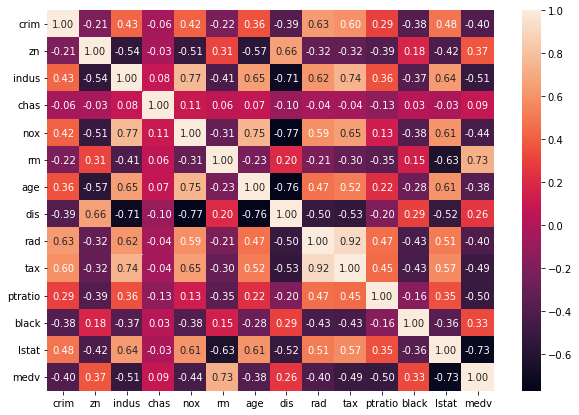

In [ ]:
#Heatmap correlation
medv_train = pd.concat([feature_medv_train, target_medv_train], axis=1)
corr = medv_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

I choose to retain tax only. Therefore, I need to drop:
- indus
- nox
- dis
- rad

In [ ]:
#Drop redundant features
feature_medv_train = feature_medv_train.drop(columns=['nox','dis','rad','indus'])
feature_medv_test = feature_medv_test.drop(columns=['nox','dis','rad','indus'])

In [ ]:
#Cek Vif score yang baru
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_medv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.676530
2,zn,1.726191
3,chas,1.035362
4,rm,1.902823
5,age,2.375245
6,tax,2.315024
7,ptratio,1.506932
8,black,1.300886
9,lstat,3.137466


Model training
  1. Ridge Regression

In [ ]:
#Split train test
from sklearn.model_selection import train_test_split

feature = medv.drop(columns='medv')
target = medv[['medv']]

feature_medv_pretrain, feature_medv_test, target_medv_pretrain, target_medv_test = train_test_split(feature, target, test_size=0.20, random_state=25)

feature_medv_train, feature_medv_validation, target_medv_train, target_medv_validation = train_test_split(feature_medv_pretrain, target_medv_pretrain, test_size=0.20, random_state=25)

In [ ]:
#Membuang kolom yang redundant
feature_medv_train = feature_medv_train.drop(columns=['nox','dis','rad','indus'])
feature_medv_validation = feature_medv_validation.drop(columns=['nox','dis','rad','indus'])
feature_medv_test = feature_medv_test.drop(columns=['nox','dis','rad','indus'])

In [ ]:
from sklearn.linear_model import Ridge

#Fit model ke training data
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

#Define the model
ridge_reg = Ridge(alpha=0.01, random_state=25)
ridge_reg2 = Ridge(alpha=0.1, random_state=25)
ridge_reg3 = Ridge(alpha=1, random_state=25)
ridge_reg4 = Ridge(alpha=10, random_state=25)

#Fit the model (training)
ridge_reg.fit(X_medv_train, y_medv_train)
ridge_reg2.fit(X_medv_train, y_medv_train)
ridge_reg3.fit(X_medv_train, y_medv_train)
ridge_reg4.fit(X_medv_train, y_medv_train)

Ridge(alpha=10, random_state=25)

In [ ]:
#Mencari RMSE terendah
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1, 10]
models = [ridge_reg,
          ridge_reg2,
          ridge_reg3,
          ridge_reg4]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.7391264916112625
RMSE of Ridge regression model with alpha = 0.1 is 5.737852159334502
RMSE of Ridge regression model with alpha = 1 is 5.7256279130641206
RMSE of Ridge regression model with alpha = 10 is 5.637733120339576


In [ ]:
#Menampilakn koefisien dari best model
ridge_best = ridge_reg4

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,7.323317
1,crim,-0.044322
2,zn,0.006336
3,chas,0.995915
4,rm,5.329122
5,age,0.007288
6,tax,-0.001310
7,ptratio,-0.872154
8,black,0.010974
9,lstat,-0.477208


**Interpretasi**: Setiap kenaikan 1 poin number room average (rm), meningkatkan harga jual rumah 5.33, apabila fitur lain bernilai tetap.

In [ ]:
#Menyiapkan prediction result dari train data
y_predict_train = ridge_best.predict(X_medv_train)

In [ ]:
#Mencari nilai RMSE, MAE dan MAPE dari data train
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_medv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_medv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_medv_train, y_predict_train)))

RMSE for training data is 4.9482508377674765
MAE for training data is 3.494665945179106
MAPE for training data is 0.18039361079148358


In [ ]:
#Mempersiapkan prediction result dari test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = ridge_best.predict(X_medv_test)

#Ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [ ]:
#Mencari nilai RMSE, MAE dan MAPE dari data test
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_medv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_medv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_medv_test, y_predict_test)))

RMSE for testing data is 5.178933915288753
MAE for testing data is 3.1723482691918563
MAPE for testing data is 0.16086137204021816


Interpretasi: 
1. MAPE pada training data < 30% dapat diartikan model tidak underfit
2. MAPE test data dan MAPE train data tidak berbeda jauh dapat diartikan model tidak overfit

LASSO

In [ ]:
from sklearn.linear_model import Lasso

#Fit Model ke Training Data
X_medv_train = feature_medv_train.to_numpy()
y_medv_train = target_medv_train.to_numpy()
y_medv_train = y_medv_train.reshape(len(y_medv_train),)

#Define the model
lasso_reg = Lasso(alpha=0.01, random_state=25)
lasso_reg2 = Lasso(alpha=0.1, random_state=25)
lasso_reg3 = Lasso(alpha=1, random_state=25)
lasso_reg4 = Lasso(alpha=10, random_state=25)

#Fit the model (training)
lasso_reg.fit(X_medv_train, y_medv_train)
lasso_reg2.fit(X_medv_train, y_medv_train)
lasso_reg3.fit(X_medv_train, y_medv_train)
lasso_reg4.fit(X_medv_train, y_medv_train)

Lasso(alpha=10, random_state=25)

In [ ]:
#Mencari nilai RMSE terkecil/terbaik
from sklearn.metrics import mean_squared_error

X_medv_validation = feature_medv_validation.to_numpy()
y_medv_validation = target_medv_validation.to_numpy()
y_medv_validation = y_medv_validation.reshape(len(y_medv_validation),)

alphas = [0.01, 0.1, 1, 10]
models = [lasso_reg,
          lasso_reg2,
          lasso_reg3,
          lasso_reg4]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_medv_validation)
    rmse = np.sqrt(mean_squared_error(y_medv_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 5.72567679990482
RMSE of Lasso regression model with alpha = 0.1 is 5.636784683839396
RMSE of Lasso regression model with alpha = 1 is 5.4438452253400085
RMSE of Lasso regression model with alpha = 10 is 6.007578533026592


In [ ]:
#Menampilkan koefisien dari best model
lasso_best = lasso_reg3

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_medv_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,24.110488
1,crim,-0.008277
2,zn,0.022232
3,chas,0.000000
4,rm,2.704088
5,age,0.026230
6,tax,-0.003640
7,ptratio,-0.768266
8,black,0.009503
9,lstat,-0.649566


**Interpretasi**: Setiap kenaikan 1 poin number room average (rm), meningkatkan harga jual rumah 2.7 , apabila fitur lain bernilai tetap.

In [ ]:
#Mencari nilai RMSE, MAE dan MAPE dari data train
y_predict_train = lasso_best.predict(X_medv_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_medv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_medv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_medv_train, y_predict_train)))

RMSE for training data is 5.252689191797853
MAE for training data is 3.7978026598683523
MAPE for training data is 0.18585661261180794


In [ ]:
#Prepare prediction result on test data
X_medv_test = feature_medv_test.to_numpy()
y_predict_test = lasso_best.predict(X_medv_test)

#Ground truth target
y_medv_test = target_medv_test.to_numpy()
y_medv_test = y_medv_test.reshape(len(y_medv_test),)

In [ ]:
#Mencari nilai RMSE, MAE dan MAPE dari data test
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_medv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_medv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_medv_test, y_predict_test)))

RMSE for testing data is 5.06573482382811
MAE for testing data is 3.278073639111597
MAPE for testing data is 0.16211562304577468


Interpretasi: 
1. MAPE pada training data < 30% dapat diartikan model tidak underfit
2. MAPE test data dan MAPE train data tidak berbeda jauh dapat diartikan model tidak overfit